In [1]:
import numpy as np
import HARK
from HARK.distribution import MVLogNormal
from scipy.optimize import root_scalar
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib import pyplot as plt

In [3]:
class BufferStockModel:

    def __init__(self, ρ = 4, Γ = 1.0216, ℜ = 1.04, Rf = 1.01, β = 0.93, Σ = np.array([[0.04/11, 0.0, 0.0], [0.0, 0.0225, 0.0], [0.0, 0.0, 0.04]])):

        self.ρ, self.Γ, self.ℜ, self.Rf, self.β, self.Σ = ρ, Γ, ℜ, Rf, β, Σ

        self.μ = - np.diag(Σ) / 2
        
        self.shocks = MVLogNormal(self.μ, self.Σ)

    def u(self, c):

        ρ = self.ρ

        if ρ == 1:
            return np.log(c)
        elif ρ >= 0:
            return (c ** (1 - ρ)) / (1 - ρ)
        else:
            raise ValueError("ρ must be non-negative")

    def u_prime(self, c):

        ρ = self.ρ

        if ρ < 0:
            raise ValueError("ρ must be non-negative")
        elif ρ == 0:
            return 1
        else:
            return c ** (-ρ)

    def m(self, a, κ, atom):

        η, ν, ζ = atom

        ℜ, Γ, Rf = self.ℜ, self.Γ, self.Rf

        R_eff = Rf + κ * (ν * ℜ - Rf)

        G_eff = Γ * η

        mNrm = R_eff * a / G_eff + ζ

        return mNrm

    def κ_euler(self, κ, a, c_next):

        Rf, ℜ, Γ, ρ, shocks_approx = self.Rf, self.ℜ, self.Γ, self.ρ, self.shocks_approx

        def ℓ(atom):
            return self.m(a, κ, atom)

        def g(atom):

            η, ν, ζ = atom

            return ((ℜ * ν) - Rf) * ((Γ * η) ** (-ρ)) * self.u_prime(c_next(ℓ(atom)))

        return shocks_approx.expected(func = g)

    def κ_hat(self, a, c_next):

        shocks_approx = self.shocks_approx

        κ_func = lambda κ : self.κ_euler(κ, a, c_next)

        κ = root_scalar(κ_func, method="newton", x0 = 0.5)['root']

        return κ

    def c_hat(self, a, κ, c_next):

        β, Rf, ℜ, Γ, ρ, shocks_approx = self.β, self.Rf, self.ℜ, self.Γ, self.ρ, self.shocks_approx

        def ℓ(atom):

            return self.m(a, κ, atom)

        def c_rho(atom):

            η, ν, ζ = atom

            return β * Rf * ((Γ * η) ** (-ρ)) * self.u_prime(c_next(ℓ(atom)))

        return shocks_approx.expected(func = c_rho) ** (-1/ρ)

    def discretize_distribution(self, N, tail_bound = [0.0015, 0.9985], decomp="cholesky", endpoints = True):

        self.shocks_approx = self.shocks._approx_equiprobable(N = N, tail_bound = tail_bound, decomp=decomp, endpoints=endpoints)

    def gen_asset_grid(self, aMax, n = 20, boroConst = True, artBoroConst = 0):

        worst = self.shocks_approx.atoms.min(axis=1)

        ηMin, νMin, ζMin = worst

        Γ, ℜ = self.Γ, self.ℜ

        if boroConst:
            if artBoroConst == 0.0:
                aMin = 1e-5
            else:
                aMin = artBoroConst
        else:
            aMin = (-ζMin) * Γ * ηMin / (ℜ * νMin)

        aDiffs = np.exp(np.linspace(-4, np.log(aMax - aMin), n-1))

        aNrmGrid = np.empty(n)

        aNrmGrid[0] = aMin
        aNrmGrid[1:] = aMin + aDiffs

        self.aNrmGrid = aNrmGrid
        self.boroConst = boroConst

    def pre_solve(self, N = 10, aMax = 6, tail_bound = [0.0015, 0.9985], decomp="cholesky", endpoints = True, n = 20, boroConst = True, artBoroConst = 0):

        self.discretize_distribution(N = N, tail_bound = tail_bound, decomp=decomp, endpoints=endpoints)

        self.gen_asset_grid(aMax = aMax, n = n, boroConst = boroConst, artBoroConst = artBoroConst)

    def solve(self, T = None, c_guess = lambda x : x, interp="linear", max_iter = 100, tol=1e-6):

        boroConst = self.boroConst
        aNrmGrid = self.aNrmGrid
        n = len(aNrmGrid)

        if T is None:
            c_T = c_guess
            t = 0
            iter = 0
            error = tol + 1
        else:
            t = T
            c_T = lambda x : x
            iter = max_iter + 1
            error = tol - 1

        policies = [{'cFunc' : c_T}]

        while (t > 0) or ((T is None) & (iter < max_iter) & (error > tol)):
            c_next = policies[-1]['cFunc']
            
            κ_hat_vec = np.vectorize(lambda a : self.κ_hat(a, c_next))

            κ_opt = κ_hat_vec(aNrmGrid)

            κGrid = np.where(κ_opt > 1, 1, np.where(κ_opt < 0, 0, κ_opt))

            def c_hat_opt(a, κ):

                return self.c_hat(a, κ, c_next)

            c_hat_vec = np.vectorize(c_hat_opt)

            cNrmGrid = c_hat_vec(aNrmGrid, κGrid)

            mNrmGrid = cNrmGrid + aNrmGrid

            if boroConst:
                κvals = np.empty(n+1)
                κvals[0] = κGrid[0]
                κvals[1:] = κGrid

                cvals = np.empty(n+1)
                cvals[0] = 0.0
                cvals[1:] = cNrmGrid

                mvals = np.zeros(n+1)
                mvals[1:] = mNrmGrid
            else:
                κvals = κGrid
                cvals = cNrmGrid
                mvals = mNrmGrid

            if interp=="linear":
                cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=1)
                κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=1)
            elif interp=="spline":
                cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=3)
                κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=3)
            elif interp=="SL":
                cFunc_t = InterpolatedUnivariateSpline(mvals, cvals, k=3)
                κFunc_t = InterpolatedUnivariateSpline(mvals, κvals, k=1)

            policies_t = {"cFunc":cFunc_t, "κFunc":κFunc_t, "mNrmGrid":mvals, "κGrid":κvals, "cNrmGrid":cvals}

            policies.append(policies_t)

            if T is not None:
                t -= 1
            else:
                iter += 1

                if iter > 1:
                    m_prev = policies[-2]['mNrmGrid']
                    κ_prev = policies[-2]['κGrid']
                    errors = np.array([np.max(np.abs(mvals - m_prev)), np.max(np.abs(κvals - κ_prev))])
                    error = np.max(errors)

        policies.reverse()

        params = {}

        if T is None:
            params['T'] = 'Infinite'
            params['error'] = error
            params['iter'] = iter
        else:
            params['T'] = T

        params['interp'] = interp

        self.policies = policies
        self.params = params

        self.gen_solution()

    def gen_solution(self):

        T = self.params['T']

        if T == 'Infinite':
            self.solution = self.policies[0]
        else:

            def solution(t : int):

                if t < 0:
                    raise ValueError("t must be non-negative")
                elif t > T:
                    raise ValueError("t must be between 0 and T")
                else:
                    return self.policies[t]

            self.solution = solution

    def plot_cFunc(self, mGrid = np.linspace(0, 10, 300), t = None):

        if (self.params['T'] == 'Infinite') and (t is not None):
            raise ValueError('The computed solution is for the infinite horizon model')
        elif (self.params['T'] != 'Infinite') and (t is None):
            raise ValueError('The solution to a finite horizon model must be provided for a given t')
        
        if t is None:
            plt.plot(mGrid, self.solution['cFunc'](mGrid), color = "black", linestyle="dashed", label = "$c(m)$")

            plt.legend()
            plt.show()
        else:
            plt.plot(mGrid, self.solution(t)['cFunc'](mGrid), color = "black", linestyle = "dashed", label = f'$c_{t}(m)$')

            plt.legend()
            plt.show()

    def plot_κFunc(self, mGrid = np.linspace(0, 10, 300), t = None):

        if (self.params['T'] == 'Infinite') and (t is not None):
            raise ValueError('The computed solution is for the infinite horizon model')
        elif (self.params['T'] != 'Infinite') and (t is None):
            raise ValueError('The solution to a finite horizon model must be provided for a given t')

        if t is None:
            plt.ylim((0, 1.1))
            plt.plot(mGrid, self.solution['κFunc'](mGrid), color = "black", label = "$\kappa(m)$")
            
            plt.legend()
            plt.show()
        else:
            plt.ylim((0, 1.1))
            plt.plot(mGrid, self.solution(t)['κFunc'](mGrid), color = "black", label = f"$\kappa_{t+1}(m)$")

            plt.legend()
            plt.show()

In [4]:
consumer = BufferStockModel(Σ = np.array([[0.01, 0.0, 0.0], [0.0, 0.0225, 0.0], [0.0, 0.0, 0.01]]))

consumer.pre_solve(aMax = 300, n=70, boroConst=True, N = 12)

consumer.solve()

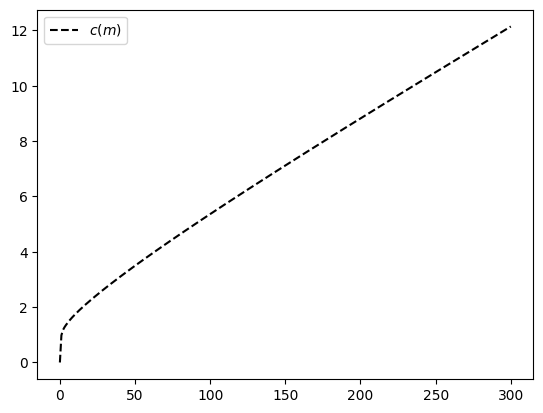

In [5]:
mGrid = np.linspace(0, 300, 300)

consumer.plot_cFunc(mGrid = mGrid)

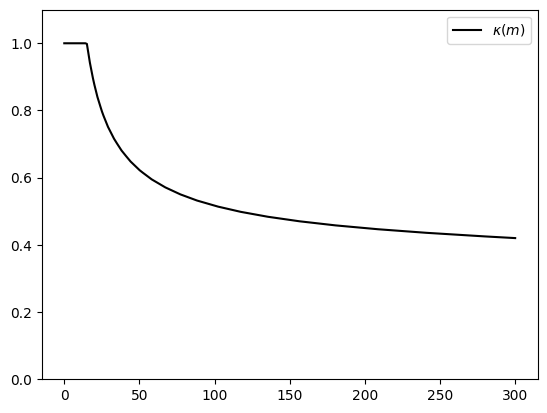

In [6]:
consumer.plot_κFunc(mGrid = mGrid)

In [7]:
def gen_cov_matrix(ω : float, kind = "P"):

    if kind == "P":
        Σ = np.array(
            [
                [0.01, ω, 0.0],
                [ω, 0.0225, 0.0],
                [0.0, 0.0, 0.01]
            ]
        )
    elif kind == "T":
        Σ = np.array(
            [
                [0.01, 0.0, 0.0],
                [0.0, 0.0225, ω],
                [0.0, ω, 0.01]
            ]
        )

    return Σ

In [15]:
Σ = gen_cov_matrix(0.008)

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 70, boroConst = True, N=12)

consumer.solve()

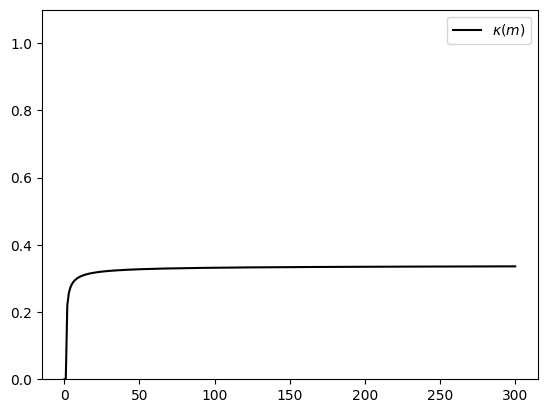

In [16]:
consumer.plot_κFunc(mGrid = mGrid)

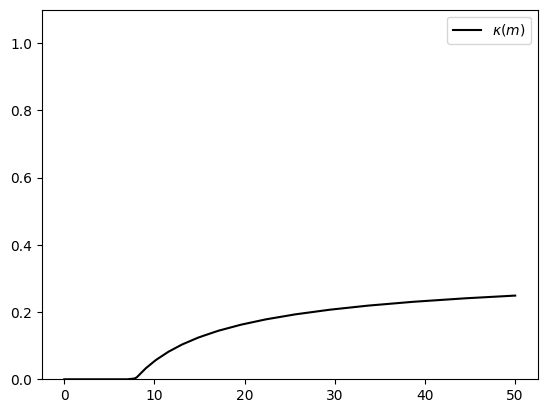

In [11]:
consumer.plot_κFunc(mGrid=np.linspace(0, 50, 200))

In [ ]:
consumer = BufferStockModel()

consumer.pre_solve(aMax = 300, n=70, boroConst=True, N=12)

consumer.solve()

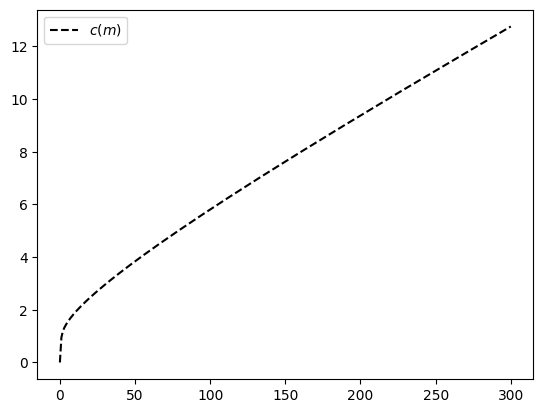

In [4]:
mGrid = np.linspace(0, 300, 300)

consumer.plot_cFunc(mGrid = mGrid)

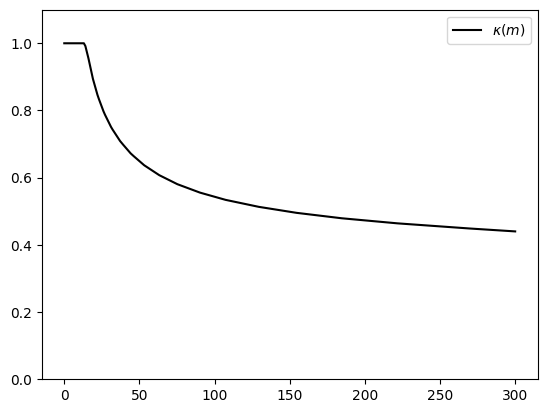

In [5]:
consumer.plot_κFunc(mGrid = mGrid)

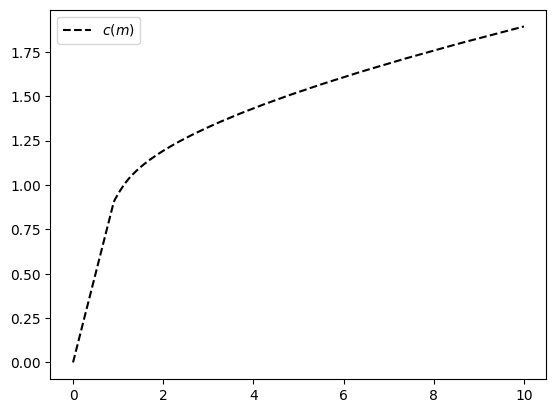

In [6]:
consumer.plot_cFunc()

In [7]:
def gen_cov_matrix(ω : float, kind = "P"):

    if kind == "P":
        Σ = np.array(
            [
                [0.04/11, ω, 0.0],
                [ω, 0.0225, 0.0],
                [0.0, 0.0, 0.04]
            ]
        )
    elif kind == "T":
        Σ = np.array(
            [
                [0.04/11, 0.0, 0.0],
                [0.0, 0.0225, ω],
                [0.0, ω, 0.04]
            ]
        )

    return Σ

In [8]:
Σ = gen_cov_matrix(0.008)

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 50, boroConst = True)

consumer.solve()

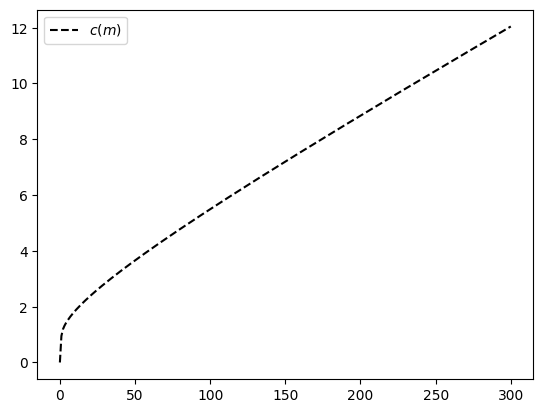

In [9]:
consumer.plot_cFunc(mGrid = mGrid)

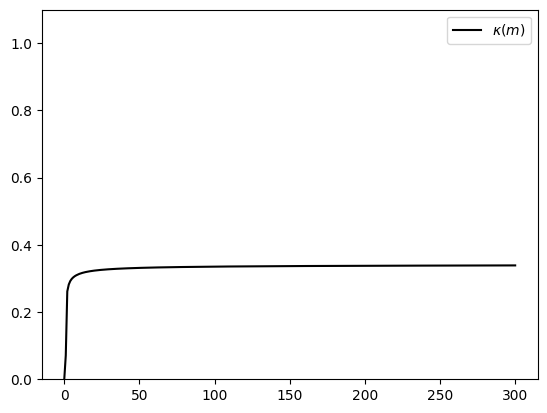

In [10]:
consumer.plot_κFunc(mGrid = mGrid)

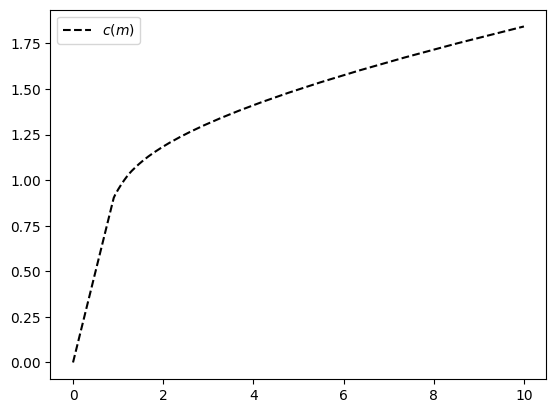

In [11]:
consumer.plot_cFunc()

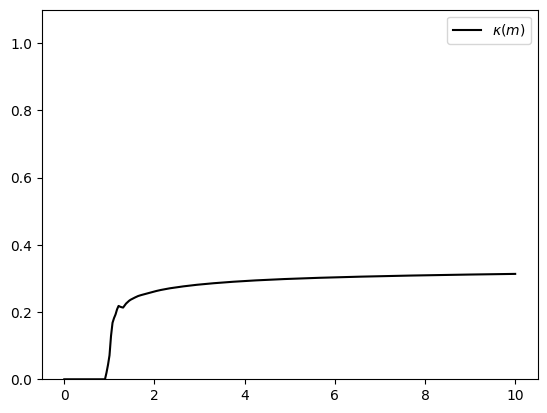

In [12]:
consumer.plot_κFunc()

In [13]:
Σ = gen_cov_matrix(0.025, kind="T")

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 50, boroConst = True)

consumer.solve()

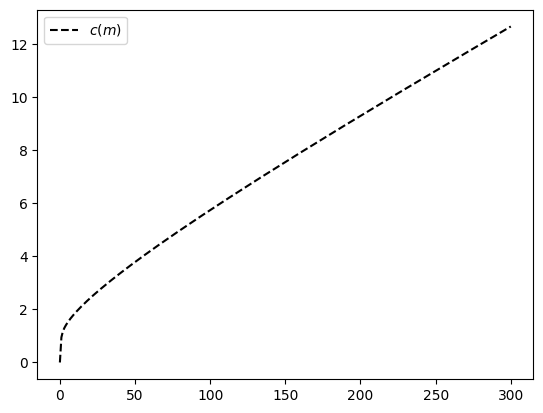

In [14]:
consumer.plot_cFunc(mGrid = mGrid)

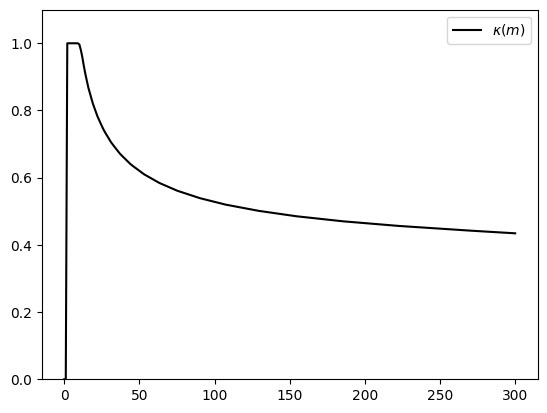

In [15]:
consumer.plot_κFunc(mGrid = mGrid)

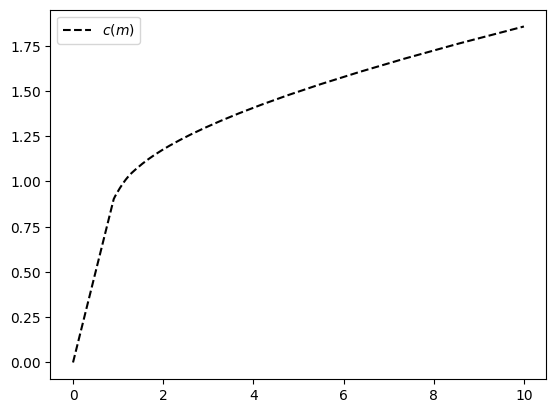

In [16]:
consumer.plot_cFunc()

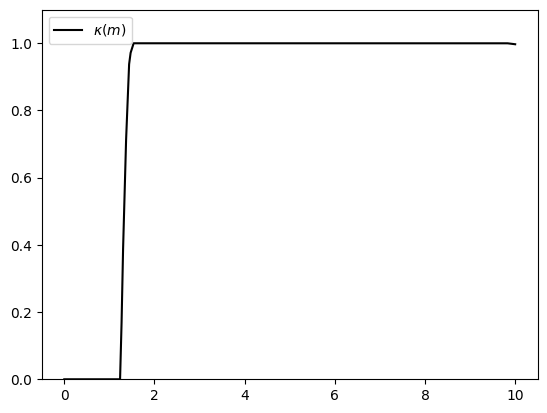

In [17]:
consumer.plot_κFunc()

In [46]:
Σ = gen_cov_matrix(0.008)

consumer = BufferStockModel(Σ = Σ)

consumer.pre_solve(aMax = 300, n= 50, boroConst = True)

consumer.solve(T = 5)

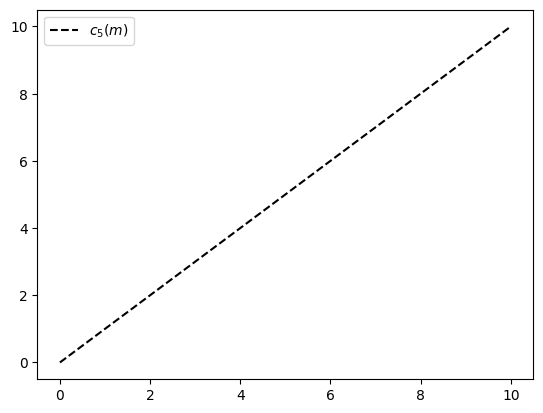

In [48]:
consumer.plot_cFunc(t=5)

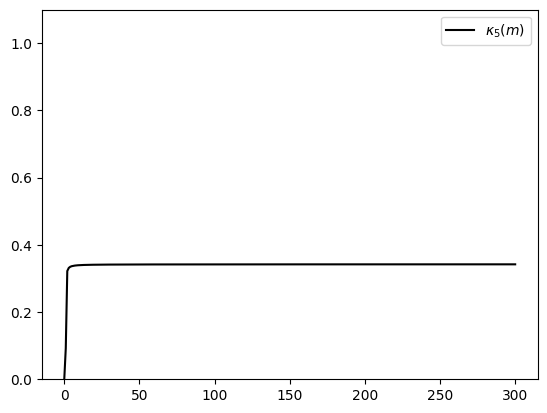

In [52]:
consumer.plot_κFunc(t=4, mGrid=mGrid)

In [15]:
ω = np.sqrt(0.011 * 0.04 / 11)

Σ = np.array(
    [
        [0.04/11, ω, 0.0],
        [ω, 0.011, 0.0],
        [0.0, 0.0, 0.04]
    ]
)

cons = BufferStockModel(ρ = 11, ℜ = 1.0767, Rf = 1.0131, Σ = Σ)

cons.pre_solve(aMax=300, n=50, boroConst=True, decomp="sqrt")

cons.solve()

In [17]:
cons.plot_κFunc(mGrid=mGrid)

NameError: name 'mGrid' is not defined

In [58]:
Σ = np.array(
    [
        [0.04/11, 0.0063, 0.0],
        [0.0063, 0.011, 0.0],
        [0.0, 0.0, 0.04]
    ]
)

cons = BufferStockModel(ρ = 12, ℜ = 1.0767, Rf = 1.0131, Σ = Σ)

cons.pre_solve(aMax=300, n=50, boroConst=True)

cons.solve()

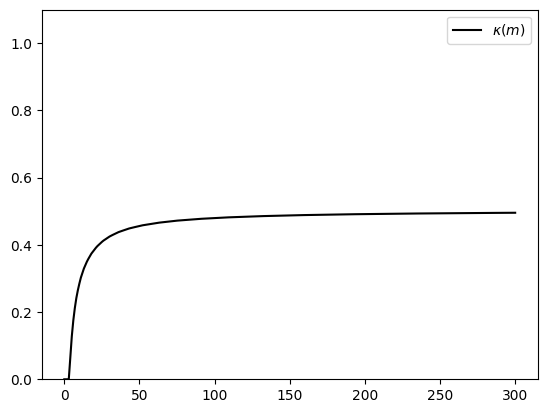

In [59]:
cons.plot_κFunc(mGrid=mGrid)

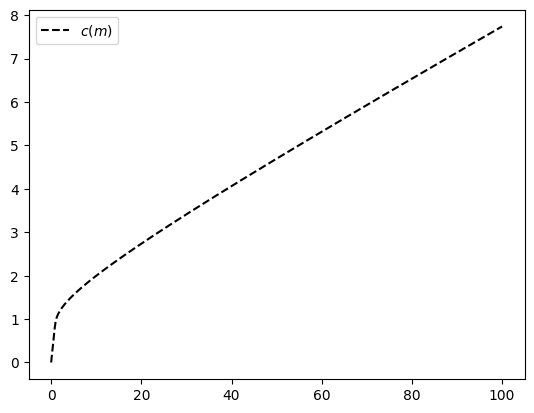

In [6]:
mGrid = np.linspace(0, 100, 500)

consumer.plot_cFunc(mGrid = mGrid)

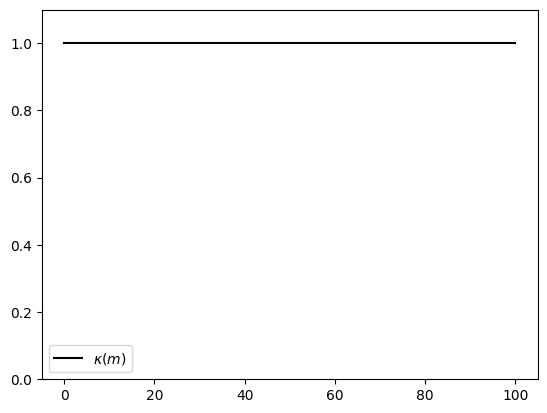

In [7]:
consumer.plot_κFunc(mGrid = mGrid)